<a href="https://colab.research.google.com/github/Beast-Hunter/ParameterOptimizationSVC/blob/main/ParameterOptimizationSVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings('ignore')

### 1. Reading the Data

In [2]:
url = "https://archive.ics.uci.edu/static/public/864/room+occupancy+estimation.zip"
!wget {url}
!unzip room+occupancy+estimation.zip


--2025-04-19 19:38:07--  https://archive.ics.uci.edu/static/public/864/room+occupancy+estimation.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘room+occupancy+estimation.zip’

room+occupancy+esti     [  <=>               ] 111.65K   558KB/s    in 0.2s    

2025-04-19 19:38:07 (558 KB/s) - ‘room+occupancy+estimation.zip’ saved [114333]

Archive:  room+occupancy+estimation.zip
  inflating: Occupancy_Estimation.csv  


In [3]:
data = pd.read_csv('/content/Occupancy_Estimation.csv')

In [4]:
data.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


### 2. Data Cleaning and Preprocessing

In [5]:
data = data.drop(['Date','Time'], axis=1)

In [6]:
X = data.drop('Room_Occupancy_Count', axis=1)
y = data['Room_Occupancy_Count']

### 3. Creating 10 samples with 70-30 ratio of Training and Testing Set

In [7]:
samples = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    samples.append((X_train, X_test, y_train, y_test))

In [8]:
samples

[(      S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  S2_Light  S3_Light  \
  8983    25.25    25.31    24.94    25.44         0         0         0   
  1142    25.69    25.75    25.38    25.94         0         0         0   
  3680    26.25    26.19    26.00    26.38       114        19       180   
  9889    25.06    25.06    24.56    25.25         0         0         1   
  8334    25.94    26.19    25.88    25.94       146       231       170   
  ...       ...      ...      ...      ...       ...       ...       ...   
  9225    25.19    25.25    24.75    25.38         0         0         0   
  4859    25.19    25.19    24.63    25.56         0         0         0   
  3264    25.88    26.81    25.50    26.25       120        26        48   
  9845    25.06    25.06    24.56    25.19         0         0         0   
  2732    25.19    25.13    24.81    25.69        12        14        58   
  
        S4_Light  S1_Sound  S2_Sound  S3_Sound  S4_Sound  S5_CO2  S5_CO2_Slope  \
  8

### 4. Defining Fitness Function and calling it for every sample

In [9]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
scaler = StandardScaler()

In [10]:
def fitnessFunction(kernel, C, gamma):
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  svm = SVC(kernel=kernel, C=C, gamma=gamma, max_iter=500)
  svm.fit(X_train_scaled, y_train)
  y_pred = svm.predict(X_test_scaled)
  return accuracy_score(y_pred, y_test)

In [11]:
result = pd.DataFrame(columns=['Sample', 'Best Accuracy', 'Best Kernel', 'Best Nu', 'Best Epsilon'])
for i in range(10):
    X_train, X_test, y_train, y_test = samples[i]
    best_accuracy = 0
    best_params = {}
    for _ in range(100):
        kernel = random.choice(kernels)
        C = random.uniform(0.1, 10)
        gamma = random.uniform(0.001, 1)
        accuracy = fitnessFunction(kernel, C, gamma)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'kernel': kernel, 'C': C, 'gamma': gamma}
    result = pd.concat([result, pd.DataFrame({'Sample': [i],
                                                'Best Accuracy': [best_accuracy],
                                                'Best Kernel': [best_params['kernel']],
                                                'Best Nu': [best_params['C']],
                                                'Best Epsilon': [best_params['gamma']]})], ignore_index=True)
result

,Sample,Best Accuracy,Best Kernel,Best Nu,Best Epsilon
0,0,0.993748,linear,0.287112,0.330975
1,1,0.995064,linear,1.777352,0.110233
2,2,0.995393,linear,0.208061,0.299521
3,3,0.995722,linear,1.532945,0.050510
4,4,0.995722,rbf,7.795876,0.068011
5,5,0.997038,rbf,5.731935,0.008321
6,6,0.994735,linear,1.217067,0.673276
7,7,0.996709,linear,2.536135,0.455535
8,8,0.992103,linear,9.910578,0.801977
9,9,0.995393,rbf,6.808169,0.068551


### 5. Plotting of the Convergence Graph

In [12]:
X_train, X_test, y_train, y_test = samples[result['Best Accuracy'].idxmax()]
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
train_sizes, train_scores, test_scores = learning_curve(SVC(kernel=result['Best Kernel'].iloc[result['Best Accuracy'].idxmax()],
                                                        C=result['Best Nu'].iloc[result['Best Accuracy'].idxmax()],
                                                        gamma=result['Best Epsilon'].iloc[result['Best Accuracy'].idxmax()],
                                                        max_iter=500),
                                                        X_train_scaled, y_train, cv=None, scoring='accuracy', n_jobs=-1,
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

In [18]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

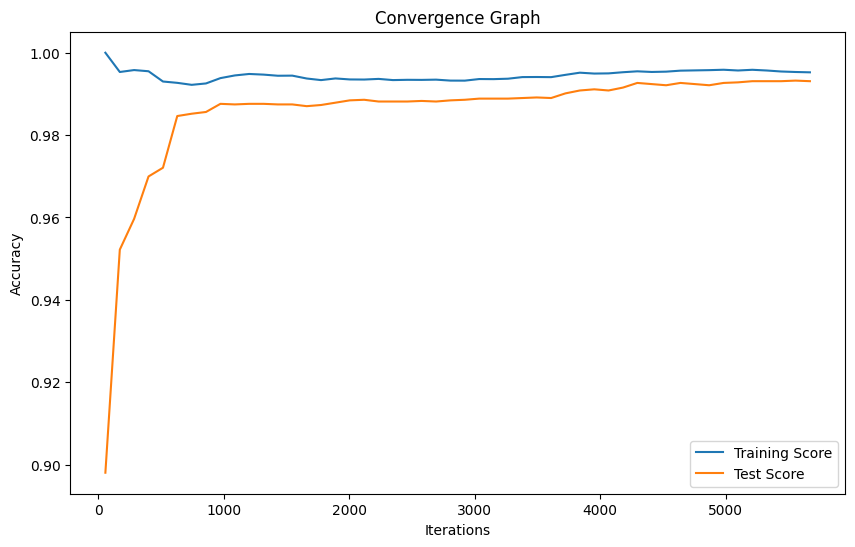

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Test Score')

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Convergence Graph')
plt.legend(loc="best")
plt.show()